In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, utils
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [ ]:
# params
batch_size = 128 
epochs = 20   
lr = 0.1      
device = 'cuda'

Files already downloaded and verified
Files already downloaded and verified


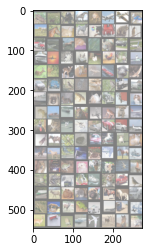

In [ ]:
# Data Loading

#data_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((125.3/255, 123.0/255, 113.9/255), (63.0/255, 62.1/255, 66.7/255)),])
#data_test_transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),])

train_transform = transforms.Compose([transforms.RandomCrop(32, padding=4), transforms.RandomHorizontalFlip(), transforms.ToTensor()])
test_transform = transforms.ToTensor()
    
trainset = datasets.CIFAR10(root='.', train=True, download=True, transform=train_transform)
testset = datasets.CIFAR10(root='.', train=False, download=True, transform=test_transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader  = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [ ]:
## network and optimizer

class rotnet(nn.Module):
    def __init__(self):
        super(rotnet, self).__init__()
        self.conv1 = nn.Conv2d(3, 192, 3)
        self.conv2 = nn.Conv2d(192, 384, 3)
        self.conv3 = nn.Conv2d(384, 4, 3)

        self.mlp1 = nn.Conv2d(192, 192, 1)
        self.mlp2 = nn.Conv2d(384, 384, 1)
        self.mlp3 = nn.Conv2d(4, 4, 1)

        self.maxpool = nn.MaxPool2d(2, stride=2)
        self.drop = nn.Dropout(0.5)
        self.bn1 = nn.BatchNorm2d(192)
        self.bn2 = nn.BatchNorm2d(384)
        self.bn3 = nn.BatchNorm2d(4)
        self.globalpool = nn.AdaptiveAvgPool2d((1,1))
        self.flat = nn.Flatten()

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.mlp1(x))
        x = F.relu(self.mlp1(x))
        x = self.maxpool(x)
        x = self.drop(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.mlp2(x))
        x = F.relu(self.mlp2(x))
        x = self.maxpool(x)
        x = self.drop(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.mlp3(x))
        x = F.relu(self.mlp3(x))
        x = self.globalpool(x)
        
        x = self.flat(x)

        return x

network = rotnet().to(device)
optimizer = optim.SGD(network.parameters(), lr=lr, weight_decay=5e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[15], gamma=0.2, verbose=True)

Adjusting learning rate of group 0 to 1.0000e-01.


In [ ]:
results_dict = {}

results_dict['rotnet_avg_loss'] = -1
results_dict['rotnet_accuracy'] = -1
results_dict['nonlinear_classifier_avg_loss'] = -1
results_dict['nonlinear_classifier_accuracy'] = -1

In [ ]:
def rotate(data, device = device):
    transform = transforms.Compose([transforms.Normalize((125.3/255, 123.0/255, 113.9/255), (63.0/255, 62.1/255, 66.7/255)),])
    data.to(device)
    transformed = []
    rotation = []
    
    for image in data:
        transformed.append(transform(image))
        rotation.append(0)

        pic = torch.transpose(image,1,2)
        pic = torch.flip(pic,[2])
        transformed.append(transform(pic))
        rotation.append(1)

        pic = torch.flip(image,[1])
        pic = torch.flip(pic,[2])
        transformed.append(transform(pic))
        rotation.append(2)

        pic = torch.flip(image,[2])
        pic = torch.transpose(pic,1,2)
        transformed.append(transform(pic))
        rotation.append(3)

        rot = torch.LongTensor(rotation)

    return (torch.stack(transformed), rot)

#batchi = iter(train_loader)
#data, target = batchi.next()
#g,h = transform(data)
#imshow(torchvision.utils.make_grid(g))

In [ ]:
def train(epochs):
    network.train()
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            #data, target = Variable(data).to(device), Variable(target).to(device)
            data, target = rotate(data)
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            output = network(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch+1, batch_idx * len(data), (len(train_loader.dataset)*4),
                    100. * batch_idx / len(train_loader), loss.item()))
        scheduler.step()

def test():
    network.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = rotate(data)
        output = network(data.to(device))
        test_loss += F.cross_entropy(output, target.to(device), reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1].to(device) # get the index of the max log-probability
        correct += pred.eq(target.to(device).data.view_as(pred)).to(device).sum()

    test_loss /= len(test_loader.dataset)*4
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, (len(test_loader.dataset)*4),
        100 * correct / (len(test_loader.dataset)*4)))
    
    results_dict['rotnet_avg_loss'] = test_loss
    results_dict['rotnet_accuracy'] = 100 * correct / (len(test_loader.dataset)*4)


In [ ]:
train(epochs)

torch.save(network.state_dict(), '/content/drive/My Drive/Colab Notebooks/rotnet.pth')

Train Epoch: 1 [0/200000 (0%)]	Loss: 1.406327
Train Epoch: 1 [51200/200000 (26%)]	Loss: 1.352768
Train Epoch: 1 [102400/200000 (51%)]	Loss: 1.298304
Train Epoch: 1 [153600/200000 (77%)]	Loss: 1.266965
Adjusting learning rate of group 0 to 1.0000e-01.
Train Epoch: 2 [0/200000 (0%)]	Loss: 1.215471
Train Epoch: 2 [51200/200000 (26%)]	Loss: 1.179353
Train Epoch: 2 [102400/200000 (51%)]	Loss: 1.298659
Train Epoch: 2 [153600/200000 (77%)]	Loss: 1.123587
Adjusting learning rate of group 0 to 1.0000e-01.
Train Epoch: 3 [0/200000 (0%)]	Loss: 1.127854
Train Epoch: 3 [51200/200000 (26%)]	Loss: 1.082920
Train Epoch: 3 [102400/200000 (51%)]	Loss: 1.068835
Train Epoch: 3 [153600/200000 (77%)]	Loss: 1.098963
Adjusting learning rate of group 0 to 1.0000e-01.
Train Epoch: 4 [0/200000 (0%)]	Loss: 1.046256
Train Epoch: 4 [51200/200000 (26%)]	Loss: 1.082987
Train Epoch: 4 [102400/200000 (51%)]	Loss: 0.969877
Train Epoch: 4 [153600/200000 (77%)]	Loss: 1.037653
Adjusting learning rate of group 0 to 1.0000e-

In [ ]:
test()


Test set: Average loss: 0.8047, Accuracy: 24762/40000 (62%)



In [ ]:
class classifier(nn.Module):
    def __init__(self, rotnet):
        super(classifier, self).__init__()
        self.rot = rotnet.to(device)
        for param in self.rot.parameters():
            param.requires_grad = False

        #self.fc1 = nn.Linear(13824, 200)
        self.fc1 = nn.Linear(64896, 200)
        self.fc2 = nn.Linear(200, 200)
        self.fc3 = nn.Linear(200, 10)

        self.bn = nn.BatchNorm1d(200)

    def forward(self, x):
        x = F.relu(self.rot.bn1(self.rot.conv1(x)))
        x = F.relu(self.rot.mlp1(x))
        x = F.relu(self.rot.mlp1(x))
        x = self.rot.maxpool(x)
        x = self.rot.drop(x)
        
        x = F.relu(self.rot.bn2(self.rot.conv2(x)))
        x = F.relu(self.rot.mlp2(x))
        x = F.relu(self.rot.mlp2(x))
        #x = self.rot.maxpool(x)
       
        #x = x.view(-1,13824)
        x = x.view(-1,64896)
        
        x = F.relu(self.bn(self.fc1(x)))
        x = F.relu(self.bn(self.fc2(x)))
        x = self.fc3(x)

        return x

#rott = rotnet().to(device)
#rott.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/rotnet.pth'))
classifier = classifier(network).to(device)
optimizer2 = optim.SGD(classifier.parameters(), lr=lr)

In [ ]:
def train_classifier(epochs):
    classifier.train()
    for epoch in range(epochs):
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = Variable(data).to(device), Variable(target).to(device)
            optimizer2.zero_grad()
            output = classifier(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer2.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch+1, batch_idx * len(data), (len(train_loader.dataset)),
                    100. * batch_idx / len(train_loader), loss.item()))
            

def test_classifier():
    classifier.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        output = classifier(data.to(device))
        test_loss += F.cross_entropy(output, target.to(device), reduction='sum').item() # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1].to(device) # get the index of the max log-probability
        correct += pred.eq(target.to(device).data.view_as(pred)).to(device).sum()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, (len(test_loader.dataset)),
        100 * correct / (len(test_loader.dataset))))
    
    results_dict['nonlinear_classifier_avg_loss'] = test_loss
    results_dict['nonlinear_classifier_accuracy'] = 100 * correct / (len(test_loader.dataset))


In [ ]:
train_classifier(epochs)

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.424518
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.129053
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.985241
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.024202
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.018540
Train Epoch: 2 [12800/50000 (26%)]	Loss: 0.899179
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.046128
Train Epoch: 2 [38400/50000 (77%)]	Loss: 0.859059
Train Epoch: 3 [0/50000 (0%)]	Loss: 0.852020
Train Epoch: 3 [12800/50000 (26%)]	Loss: 0.668188
Train Epoch: 3 [25600/50000 (51%)]	Loss: 0.823647
Train Epoch: 3 [38400/50000 (77%)]	Loss: 0.721240
Train Epoch: 4 [0/50000 (0%)]	Loss: 0.836828
Train Epoch: 4 [12800/50000 (26%)]	Loss: 0.848089
Train Epoch: 4 [25600/50000 (51%)]	Loss: 0.869676
Train Epoch: 4 [38400/50000 (77%)]	Loss: 0.833070
Train Epoch: 5 [0/50000 (0%)]	Loss: 0.859424
Train Epoch: 5 [12800/50000 (26%)]	Loss: 0.808213
Train Epoch: 5 [25600/50000 (51%)]	Loss: 0.769378
Train Epoch: 5 [38400/50000 (77%)]	Loss: 0.664122
Train Epoch: 6 [0/50000 (

In [26]:
test_classifier()


Test set: Average loss: 1.0300, Accuracy: 6429/10000 (64%)



In [29]:
pickle.dump( results_dict, open( "/content/drive/My Drive/Colab Notebooks/saverot.p", "wb" ) )